Create a Custom CNN for inaturalist dataset


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

ACTIVATIONS = {
    "relu": nn.ReLU,
    "gelu": nn.GELU,
    "silu": nn.SiLU,
    "mish": nn.Mish
}

class CustomCNN(nn.Module):
    def __init__(self, input_channels, conv_configs, dense_neurons, num_classes):
        super(CustomCNN, self).__init__()

        layers = []
        in_channels = input_channels

        for cfg in conv_configs:
            out_channels = cfg['out_channels']
            kernel_size = cfg['kernel_size']
            activation = ACTIVATIONS[cfg['activation'].lower()]()

            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2))
            layers.append(activation)
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)

        dummy_input = torch.zeros(1, input_channels, 64, 64)
        conv_out = self.conv(dummy_input)
        flatten_dim = conv_out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flatten_dim, dense_neurons)
        self.output = nn.Linear(dense_neurons, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.output(x)
        return x


In [ ]:
from torchsummary import summary

conv_configs = [
    {"out_channels": 32, "kernel_size": 3, "activation": "ReLU"},
    {"out_channels": 64, "kernel_size": 3, "activation": "ReLU"},
]

model = CustomCNN(input_channels=3, conv_configs=conv_configs, dense_neurons=128, num_classes=10)

# Move the model to the appropriate device before calling summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Pass the device string instead of the device object
summary(model, input_size=(3, 64, 64), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Linear-7                  [-1, 128]       2,097,280
            Linear-8                   [-1, 10]           1,290
Total params: 2,117,962
Trainable params: 2,117,962
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.38
Params size (MB): 8.08
Estimated Total Size (MB): 11.50
----------------------------------------------------------------


Data Setup

In [ ]:
#Rename val folder as test
!mv /content/drive/MyDrive/nature_12K/inaturalist_12K/val /content/drive/MyDrive/nature_12K/inaturalist_12K/test


In [ ]:
#Data Split
import os
import shutil
import random
from collections import defaultdict
from tqdm import tqdm

def stratified_split_train_val(train_dir, val_dir, val_ratio=0.2):
    # No need to create val_dir, it is passed as an argument
    os.makedirs(val_dir, exist_ok=True)

    class_to_images = defaultdict(list)

    for cls in os.listdir(train_dir):
        cls_path = os.path.join(train_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        for img_file in os.listdir(cls_path):
            class_to_images[cls].append(os.path.join(cls_path, img_file))

    for cls, images in tqdm(class_to_images.items(), desc="Splitting into val set"):
        random.shuffle(images)
        n_val = int(len(images) * val_ratio)

        val_cls_path = os.path.join(val_dir, cls)
        os.makedirs(val_cls_path, exist_ok=True)

        for img_path in images[:n_val]:
            shutil.move(img_path, os.path.join(val_cls_path, os.path.basename(img_path)))

# Define the paths explicitly
train_path = '/content/drive/MyDrive/nature_12K/inaturalist_12K/train'
val_path = '/content/drive/MyDrive/nature_12K/inaturalist_12K/val'

# Create the validation set
stratified_split_train_val(train_path, val_path)

Splitting into val set: 100%|██████████| 10/10 [00:00<00:00, 37.50it/s]


In [ ]:
#Transform the data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/nature_12K/inaturalist_12K/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
!pip install wandb
import wandb
wandb.login()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: me21b118 (me21b118-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Define functions for training and evaluating the model  

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, config):
    wandb.init(project='da6401-assignment2', config=config)
    config = wandb.config

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)

    for epoch in range(config.epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader, device)
        wandb.log({"train_loss": train_loss / len(train_loader), "train_acc": train_acc, "val_acc": val_acc})

    wandb.finish()

def evaluate_model(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return correct / total


Training model with some hyperparamaters

In [ ]:
config = {
    "lr": 0.001,
    "epochs": 20,
    "dense_neurons": 128
}

model = CustomCNN(
    input_channels=3,
    conv_configs=[
        {"out_channels": 32, "kernel_size": 3, "activation": "ReLU"},
        {"out_channels": 64, "kernel_size": 3, "activation": "ReLU"},
    ],
    dense_neurons=config["dense_neurons"],
    num_classes=10
)

train_model(model, train_loader, val_loader, config)


train_acc,▁▁▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇███
train_loss,█▇▇▇▇▆▆▆▅▅▄▄▃▃▂▂▂▁▁▁
val_acc,▁▁▅█▆█▆▇▆▆▆▆▅▄▆▆▆▃▅▆
train_acc,0.96313
train_loss,0.23244
val_acc,0.22


Configuration for hyperparameter Sweep

In [ ]:
sweep_config = {
    'method': 'bayes',  # or 'grid' / 'random'
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.01, 0.001, 0.0005]
        },
        'epochs': {
            'values': [10, 20, 30]
        },
        'dense_neurons': {
            'values': [64, 128, 256]
        },
        'activation': {
            'values': ['ReLU', 'GELU', 'SiLU']
        },
        'filters_layer1': {
            'values': [16, 32, 64]
        },
        'filters_layer2': {
            'values': [32, 64, 128]
        },
        'kernel_size': {
            'values': [3, 5]
        }
    }
}



Train the model for all the sweeps

In [ ]:
def sweep_train():
    wandb.init(project="da6401-assignment2")
    config = wandb.config

    conv_configs = [
        {'out_channels': config.filters_layer1, 'kernel_size': config.kernel_size, 'activation': config.activation},
        {'out_channels': config.filters_layer2, 'kernel_size': config.kernel_size, 'activation': config.activation}
    ]

    model = CustomCNN(
        input_channels=3,
        conv_configs=conv_configs,
        dense_neurons=config.dense_neurons,
        num_classes=10
    )

    train_model(model, train_loader, val_loader, config)


In [ ]:
# Create sweep
sweep_id = wandb.sweep(sweep_config, project="da6401-assignment2")

# Run the sweep agent (runs 1 trial, repeat to run more)
wandb.agent(sweep_id, function=sweep_train, count=25)


Create sweep with ID: yo97gabh
Sweep URL: https://wandb.ai/me21b118-iit-madras/da6401-assignment2/sweeps/yo97gabh


wandb: Agent Starting Run: 9qhp7fgy with config:
wandb: 	activation: SiLU
wandb: 	dense_neurons: 64
wandb: 	epochs: 20
wandb: 	filters_layer1: 16
wandb: 	filters_layer2: 64
wandb: 	kernel_size: 3
wandb: 	lr: 0.01


train_acc,▁▁▁▂▁▃▃▃▄▅▅▅▅▆▆▆▇▇▇█
train_loss,█▅▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▂▂▃▅█▄▇█▆▅▆▅▆▅▄▄▄▄▄
train_acc,0.69816
train_loss,0.97108
val_acc,0.17


wandb: Agent Starting Run: 5qu4xqd6 with config:
wandb: 	activation: GELU
wandb: 	dense_neurons: 256
wandb: 	epochs: 10
wandb: 	filters_layer1: 16
wandb: 	filters_layer2: 32
wandb: 	kernel_size: 5
wandb: 	lr: 0.01


train_acc,▄▁▃▅▁▂▂▂█▆
train_loss,█▄▆▄▃▃▂▂▁▁
val_acc,▃▁▃▃▃▂▆▃██
train_acc,0.12442
train_loss,3.36577
val_acc,0.14


wandb: Agent Starting Run: mqlsqzof with config:
wandb: 	activation: GELU
wandb: 	dense_neurons: 128
wandb: 	epochs: 30
wandb: 	filters_layer1: 16
wandb: 	filters_layer2: 64
wandb: 	kernel_size: 5
wandb: 	lr: 0.001


train_acc,▁▂▂▂▃▃▄▄▄▅▅▆▆▇▇▇▇▇████████████
train_loss,█▇▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▅▆▇▄▆█▆▅▃▃▄▄▃▅▄▅▄▃▅▄▄▄▅▃▄▃▃▃
train_acc,0.99539
train_loss,0.01829
val_acc,0.17


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b8jvvr56 with config:
wandb: 	activation: ReLU
wandb: 	dense_neurons: 256
wandb: 	epochs: 30
wandb: 	filters_layer1: 16
wandb: 	filters_layer2: 32
wandb: 	kernel_size: 5
wandb: 	lr: 0.001


train_acc,▁▁▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇███████
train_loss,█▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁
val_acc,▁▃▅▆▁▆▄▆▆▆▄▇▆█▄▆▆▅▄▃▅▅▆▄▅▅▅▅▃▅
train_acc,0.98618
train_loss,0.11347
val_acc,0.22


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i006kk94 with config:
wandb: 	activation: GELU
wandb: 	dense_neurons: 64
wandb: 	epochs: 20
wandb: 	filters_layer1: 64
wandb: 	filters_layer2: 128
wandb: 	kernel_size: 5
wandb: 	lr: 0.0005


train_acc,▁▂▂▂▃▃▄▄▅▅▅▆▆▇▇█████
train_loss,██▇▇▇▆▆▆▅▄▄▃▃▂▂▂▂▁▁▁
val_acc,▁▁▆▇█▅▅▇▄▄▆▃▄▄▃▂▆▂▃▅
train_acc,0.98387
train_loss,0.11967
val_acc,0.2


wandb: Agent Starting Run: kp8q04qh with config:
wandb: 	activation: SiLU
wandb: 	dense_neurons: 128
wandb: 	epochs: 10
wandb: 	filters_layer1: 16
wandb: 	filters_layer2: 32
wandb: 	kernel_size: 5
wandb: 	lr: 0.0005


train_acc,▁▂▃▅▅▆▇▇██
train_loss,█▇▇▆▅▅▄▃▂▁
val_acc,▂▄▁▅█▆▅▅▆▃
train_acc,0.38249
train_loss,1.80132
val_acc,0.16


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3b4c3gca with config:
wandb: 	activation: SiLU
wandb: 	dense_neurons: 128
wandb: 	epochs: 10
wandb: 	filters_layer1: 64
wandb: 	filters_layer2: 32
wandb: 	kernel_size: 3
wandb: 	lr: 0.0005


train_acc,▁▂▃▄▄▅▅▆▇█
train_loss,█▇▇▆▅▄▄▃▂▁
val_acc,▁▃▆▆▇▇▆█▆▆
train_acc,0.4977
train_loss,1.66814
val_acc,0.2


wandb: Agent Starting Run: uz4ybkde with config:
wandb: 	activation: ReLU
wandb: 	dense_neurons: 256
wandb: 	epochs: 20
wandb: 	filters_layer1: 32
wandb: 	filters_layer2: 32
wandb: 	kernel_size: 5
wandb: 	lr: 0.001


train_acc,▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇███
train_loss,███▇▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁
val_acc,▂▁▂▃▁▆▄▇▄█▆▇▇▄▅█▁█▂▃
train_acc,0.93318
train_loss,0.26961
val_acc,0.15


wandb: Agent Starting Run: wf7n5lmu with config:
wandb: 	activation: GELU
wandb: 	dense_neurons: 64
wandb: 	epochs: 10
wandb: 	filters_layer1: 64
wandb: 	filters_layer2: 64
wandb: 	kernel_size: 3
wandb: 	lr: 0.01


train_acc,▃▂▁▁▁▂▅▃▆█
train_loss,█▃▄▂▂▁▁▁▁▁
val_acc,▂▃▂▁▁▅▂▅▇█
train_acc,0.25576
train_loss,2.05378
val_acc,0.2


wandb: Agent Starting Run: sp6fgklp with config:
wandb: 	activation: ReLU
wandb: 	dense_neurons: 256
wandb: 	epochs: 30
wandb: 	filters_layer1: 64
wandb: 	filters_layer2: 32
wandb: 	kernel_size: 5
wandb: 	lr: 0.01


train_acc,▃▆▆▅▅▄█▃▄▄▅▂▄▃▁▄▅▄▅▅▅▃▅▂▆▃▂▄▄▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▄▂▁█▄█▄▇▂▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
train_acc,0.07373
train_loss,2.30551
val_acc,0.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b67igg8t with config:
wandb: 	activation: ReLU
wandb: 	dense_neurons: 64
wandb: 	epochs: 30
wandb: 	filters_layer1: 16
wandb: 	filters_layer2: 32
wandb: 	kernel_size: 3
wandb: 	lr: 0.01


train_acc,▁▁▁▁▁▂▂▂▃▄▄▅▅▆▆▇▇▇▇▇▇█████████
train_loss,█▆▆▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▂▂▂▂▃▄▆▄▁▁▄▃▃▅▂▆▃▃▃▅█▄▄▄▃▆▅▃▁▄
train_acc,0.95853
train_loss,0.15333
val_acc,0.13


wandb: Agent Starting Run: 8kzlbixj with config:
wandb: 	activation: SiLU
wandb: 	dense_neurons: 64
wandb: 	epochs: 20
wandb: 	filters_layer1: 32
wandb: 	filters_layer2: 128
wandb: 	kernel_size: 3
wandb: 	lr: 0.0005


train_acc,▁▂▂▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇█
train_loss,█▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁
val_acc,▄▁▄▄▇▇█▆▆▆▃▂▄▃▂▃▄▂▂▃
train_acc,0.79493
train_loss,0.83015
val_acc,0.18


wandb: Agent Starting Run: 9opxfyro with config:
wandb: 	activation: SiLU
wandb: 	dense_neurons: 64
wandb: 	epochs: 30
wandb: 	filters_layer1: 16
wandb: 	filters_layer2: 128
wandb: 	kernel_size: 5
wandb: 	lr: 0.01


train_acc,▂▁▁▁▁▂▂▂▂▂▂▂▂▃▄▄▄▅▅▅▆▆▇▆▇▇▇█▇█
train_loss,█▅▅▄▅▆▃▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▁▂▂▂▃▂▂▃▂▃▂▃▄▄█▅▇█▄▇▇▆█▇▅▅▇▅█
train_acc,0.53917
train_loss,1.53778
val_acc,0.26


wandb: Agent Starting Run: 8kiz1qam with config:
wandb: 	activation: GELU
wandb: 	dense_neurons: 128
wandb: 	epochs: 20
wandb: 	filters_layer1: 16
wandb: 	filters_layer2: 128
wandb: 	kernel_size: 3
wandb: 	lr: 0.01


train_acc,▁▁▁▂▂▂▃▃▄▄▅▅▆▆▆▇▇███
train_loss,█▆▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▃▁▂▆▃▄▁▆▇█▇▆▆▄▇███▇▆
train_acc,0.90323
train_loss,0.42846
val_acc,0.18


wandb: Agent Starting Run: i34q1k0t with config:
wandb: 	activation: SiLU
wandb: 	dense_neurons: 128
wandb: 	epochs: 10
wandb: 	filters_layer1: 16
wandb: 	filters_layer2: 64
wandb: 	kernel_size: 5
wandb: 	lr: 0.01


train_acc,▄▃▅▁▁▅▅▆██
train_loss,█▅▆▄▂▂▁▁▁▁
val_acc,▂▂▄▁▁▅▅█▆▅
train_acc,0.17281
train_loss,2.45463
val_acc,0.15


wandb: Agent Starting Run: 4wsbzk5l with config:
wandb: 	activation: GELU
wandb: 	dense_neurons: 256
wandb: 	epochs: 30
wandb: 	filters_layer1: 64
wandb: 	filters_layer2: 32
wandb: 	kernel_size: 5
wandb: 	lr: 0.001


train_acc,▁▁▁▂▂▃▃▃▃▄▅▅▆▆▆▆▇▇████████████
train_loss,█▇▇▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▃▄▇█▆▆▆▇▆▂▃▄▃▆▂▃▅▅▅▃▅▅▄▅▄▄▄
train_acc,0.9977
train_loss,0.0163
val_acc,0.17


wandb: Agent Starting Run: xu23vfln with config:
wandb: 	activation: ReLU
wandb: 	dense_neurons: 256
wandb: 	epochs: 10
wandb: 	filters_layer1: 32
wandb: 	filters_layer2: 32
wandb: 	kernel_size: 3
wandb: 	lr: 0.0005


train_acc,▁▂▄▅▅▅▆███
train_loss,█▇▆▆▅▄▃▂▁▁
val_acc,▁▃▆█▇▆▇▇▄▅
train_acc,0.49309
train_loss,1.55009
val_acc,0.2


wandb: Agent Starting Run: 9871k8i6 with config:
wandb: 	activation: SiLU
wandb: 	dense_neurons: 128
wandb: 	epochs: 20
wandb: 	filters_layer1: 16
wandb: 	filters_layer2: 128
wandb: 	kernel_size: 5
wandb: 	lr: 0.01


train_acc,▁▂▂▂▁▃▁▂▁▂▃▃▃▄▆▅▆▆▇█
train_loss,██▆▅▄▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▁▂▂▂▁▂▁▁▂▃▂▃▃▅▅▄█▇▆
train_acc,0.26959
train_loss,2.03561
val_acc,0.18


wandb: Agent Starting Run: 0w14ooa0 with config:
wandb: 	activation: SiLU
wandb: 	dense_neurons: 128
wandb: 	epochs: 30
wandb: 	filters_layer1: 16
wandb: 	filters_layer2: 128
wandb: 	kernel_size: 5
wandb: 	lr: 0.001


train_acc,▁▂▂▃▃▄▄▅▅▅▆▆▇▇▇███████████████
train_loss,█▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▅▄▇█▇▇▄▂▄▂▂▂▂▁▅▄▅▃▅▃▄▅▄▄▅▅▅▅▄▄
train_acc,1
train_loss,0.0121
val_acc,0.19


wandb: Agent Starting Run: jqhbgb9n with config:
wandb: 	activation: SiLU
wandb: 	dense_neurons: 128
wandb: 	epochs: 30
wandb: 	filters_layer1: 32
wandb: 	filters_layer2: 128
wandb: 	kernel_size: 5
wandb: 	lr: 0.01


train_acc,▂▁▂▃▃▃▃▃▃▃▄▄▅▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇██
train_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂█▅▅▅▄▅▄▁▂▂▁▄▄▄▄▅▅▄▄▄▅▅▅▅▅▅▅▅▅
train_acc,0.24194
train_loss,2.04883
val_acc,0.11


wandb: Agent Starting Run: m0eylpkx with config:
wandb: 	activation: SiLU
wandb: 	dense_neurons: 128
wandb: 	epochs: 10
wandb: 	filters_layer1: 16
wandb: 	filters_layer2: 32
wandb: 	kernel_size: 3
wandb: 	lr: 0.01


train_acc,▁▁▂▂▃▃▅▆▇█
train_loss,█▅▅▃▂▂▂▂▁▁
val_acc,▁▁▂▂▂▅▆██▆
train_acc,0.51152
train_loss,1.55289
val_acc,0.2


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1h2dvh31 with config:
wandb: 	activation: GELU
wandb: 	dense_neurons: 64
wandb: 	epochs: 10
wandb: 	filters_layer1: 32
wandb: 	filters_layer2: 128
wandb: 	kernel_size: 3
wandb: 	lr: 0.0005


train_acc,▁▂▄▅▅▆▇▆██
train_loss,█▇▆▅▅▄▃▃▂▁
val_acc,▁▅▅▇▆█▇▆█▆
train_acc,0.51152
train_loss,1.57728
val_acc,0.22


wandb: Agent Starting Run: pxlmdsx3 with config:
wandb: 	activation: ReLU
wandb: 	dense_neurons: 256
wandb: 	epochs: 10
wandb: 	filters_layer1: 32
wandb: 	filters_layer2: 32
wandb: 	kernel_size: 3
wandb: 	lr: 0.0005


train_acc,▁▂▃▄▅▆▇▇██
train_loss,█▇▇▆▅▅▄▃▂▁
val_acc,▁▁▆▃▆▇▇██▅
train_acc,0.49309
train_loss,1.57396
val_acc,0.22


wandb: Agent Starting Run: ee3d3dlz with config:
wandb: 	activation: GELU
wandb: 	dense_neurons: 64
wandb: 	epochs: 20
wandb: 	filters_layer1: 32
wandb: 	filters_layer2: 128
wandb: 	kernel_size: 5
wandb: 	lr: 0.001


train_acc,▁▂▂▃▃▄▄▄▅▅▆▆▇▇▇█████
train_loss,█▇▇▇▆▆▅▅▅▄▄▃▂▂▂▂▁▁▁▁
val_acc,▂▃▄▅█▃▆▂▄▄▃▄▄▁▁▂▂▃▂▁
train_acc,0.98618
train_loss,0.08099
val_acc,0.15


wandb: Agent Starting Run: c9f8ct5t with config:
wandb: 	activation: ReLU
wandb: 	dense_neurons: 128
wandb: 	epochs: 20
wandb: 	filters_layer1: 64
wandb: 	filters_layer2: 32
wandb: 	kernel_size: 5
wandb: 	lr: 0.01


train_acc,▄▇▆▃▅▃▁▅▇▇▇▆▇▇█▇█▇▅▄
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▇▇▇▇▇▇▇▇▇▇█▇▇▇▇████
train_acc,0.09677
train_loss,2.26539
val_acc,0.11


Best model across all the sweeps is vivid-spaceship-17 with a validation accuracy of 0.2615
Hyperparameters: dense_neurons = 128, epochs = 10, lr = 0.001


In [ ]:
best_model = CustomCNN(
    input_channels=3,
    conv_configs=[
        {"out_channels": 32, "kernel_size": 3, "activation": "ReLU"},
        {"out_channels": 64, "kernel_size": 3, "activation": "ReLU"},
    ],
    dense_neurons=config["dense_neurons"],
    num_classes=10
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.0, 0.0, 0.0])
    std = np.array([1.0, 1.0, 1.0])
    inp = std * inp + mean  # unnormalize if needed
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title, fontsize=8)
    plt.axis('off')

def show_predictions_grid(model, test_loader, class_names, device='cuda'):
    model.eval()
    images_shown = 0
    num_rows, num_cols = 10, 3  # 10x3 grid = 30 images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 30))
    fig.tight_layout(pad=3.0)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_rows * num_cols:
                    break
                row = images_shown // num_cols
                col = images_shown % num_cols

                img = images[i].cpu().permute(1, 2, 0)  # CxHxW to HxWxC
                img = img * 0.5 + 0.5  # unnormalize if normalized with mean=0.5, std=0.5
                axes[row, col].imshow(img.numpy())
                axes[row, col].axis('off')
                axes[row, col].set_title(
                    f"GT: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}",
                    fontsize=8
                )
                images_shown += 1

            if images_shown >= num_rows * num_cols:
                break

    plt.subplots_adjust(hspace=0.6)
    plt.show()


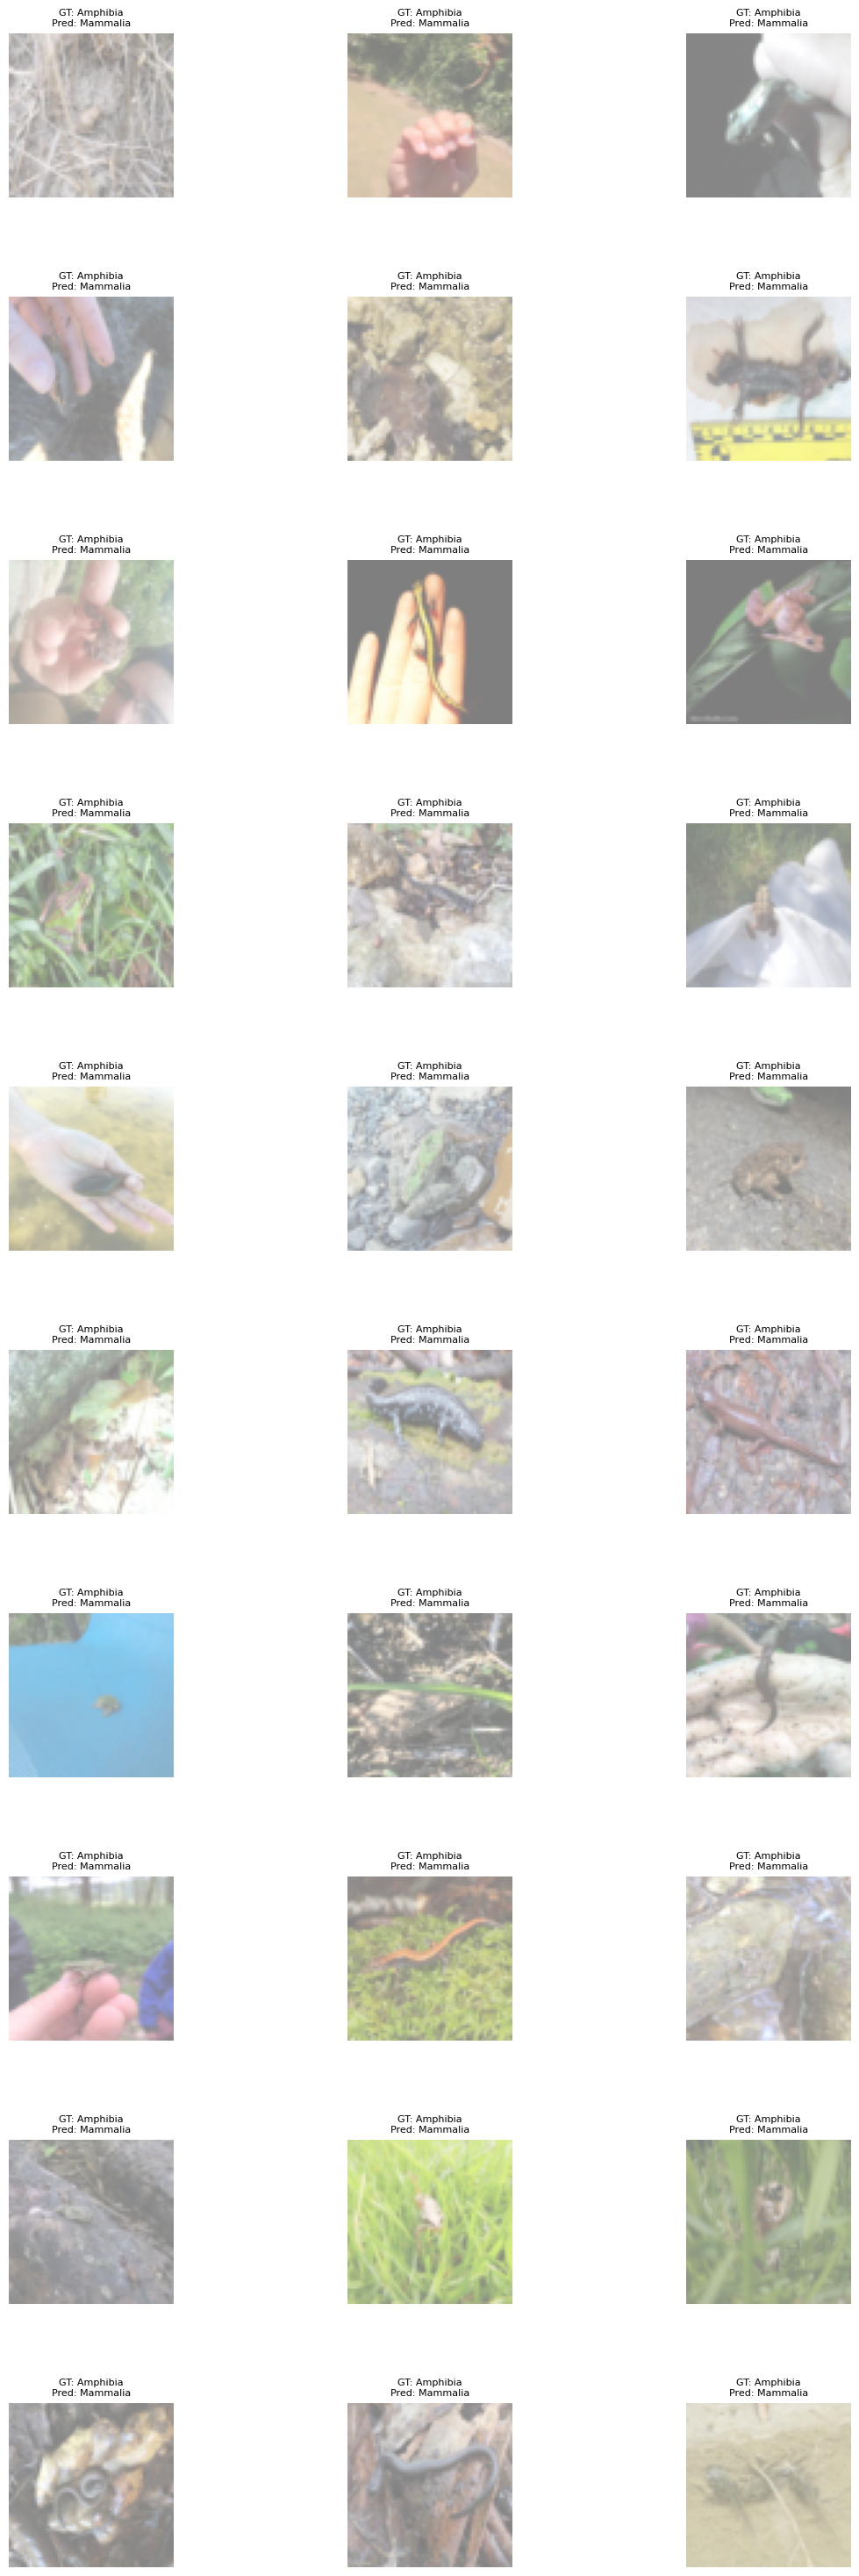

In [ ]:
class_names = test_dataset.classes  # from ImageFolder
# Move the best_model to the GPU before inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

show_predictions_grid(best_model, test_loader, class_names, device=device)
